# Make the photometry of the companion star

- author : Sylvie Dagoret
- date June 19 2019

Use Photutils

https://informatique-python.readthedocs.io/fr/m2/Cours/astropy.html

https://informatique-python.readthedocs.io/fr/m2/

In [1]:
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

import numpy as np

from scipy.interpolate import interp1d

from astropy.time import Time
from astropy.io import fits

In [2]:
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture
#from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import (ImageNormalize,MinMaxInterval, SqrtStretch)

from photutils import DAOStarFinder
from photutils import make_source_mask
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground

In [3]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(15,15)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

In [4]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    
    For example for the PSF
    
    x=pixel number
    y=Intensity in pixel
    
    values-x
    weights=y=f(x)
    
    """
    average = np.average(values, weights=weights)
    variance = np.average((values - average) ** 2, weights=weights)  # Fast and numerically precise
    return average, np.sqrt(variance)


In [5]:
def Show2Histo(data1,data2,title1,title2,cutmax=10):
    """
    """
    vmin1=data1.min()
    vmax1=data1.max()/cutmax
    vmin2=data2.min()
    vmax2=data2.max()/cutmax
  
    
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.hist(data1.flatten(),bins=100,range=(vmin1,vmax1))
    plt.grid(color="k")
    plt.title(title1)
    
    
    plt.subplot(222)
    plt.hist(data2.flatten(),bins=100,range=(vmin2,vmax2))
    
    plt.grid(color="k")
    plt.title(title2)

In [6]:
def Show2Images(data1,data2,title1,title2,cutmax=10,normflag=False):
    """
    """
    norm1 = ImageNormalize(data1, interval=MinMaxInterval(),stretch=SqrtStretch())
    norm2 = ImageNormalize(data2, interval=MinMaxInterval(),stretch=SqrtStretch())


    
    vmin1=data1.min()
    vmax1=data1.max()/cutmax
    vmin2=data2.min()
    vmax2=data2.max()/cutmax
    
    norm = ImageNormalize(stretch=SqrtStretch())
    
    plt.figure(figsize=(20,26))
    plt.subplot(221)
    if normflag:
        img1=plt.imshow(data1,origin="lower",cmap="jet",vmin=vmin1,vmax=vmax1,norm=norm1)
    else:
        img1=plt.imshow(data1,origin="lower",cmap="jet",vmin=vmin1,vmax=vmax1)
    plt.grid(color="w")
    plt.title(title1)
    plt.xlabel(" X - pixel ")
    plt.ylabel(" Y - pixel ")
    plt.colorbar(img1,orientation="horizontal")
    plt.subplot(222)
    if normflag:
        img2=plt.imshow(data2,origin="lower",cmap="jet",vmin=vmin2,vmax=vmax2,norm=norm2)
    else:
        img2=plt.imshow(data2,origin="lower",cmap="jet",vmin=vmin2,vmax=vmax2)
    plt.grid(color="w")
    plt.title(title2)
    plt.xlabel(" X - pixel ")
    plt.ylabel(" Y - pixel ")
    plt.colorbar(img2,orientation="horizontal")

In [7]:
def FindSources(data):
    """
    """
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=10.0, threshold=10.*std)    
    sources = daofind(data - median) 
    #sources = daofind(data) 
    return sources

In [8]:
def GetExtractionParam(sources,width=20):
    """
    """
    
    y0=sources["ycentroid"][0]
    x0=sources["xcentroid"][0]

    xmin=int(x0-width)
    xmax=int(x0+width)
    ymin=int(y0-width)
    ymax=int(y0+width)
    
    return x0,y0,xmin,xmax,ymin,ymax

In [9]:
def GetBackground(data):
    """
    """
    #mask = make_source_mask(data, snr=3, npixels=5, dilate_size=11)
    mask = make_source_mask(data, snr=3, npixels=10)
    mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
    print((mean, median, std))  
    
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (20, 20), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    
    return bkg  

In [10]:
# where are the spectra
#----------------------
thedate = "20190215"
rawinput_directory="/Users/dagoret/DATA/PicDuMidiFev2019/prod_"+thedate+"_v4"

In [11]:
file1="T1M_20190215_225550_730_HD116405_Filtre_None_bin1x1.1_red.fit" 
file2="T1M_20190216_040015_897_HD116405_Filtre_None_bin1x1.346_red.fit"

In [12]:
title1=file1.split("_Filtre_None_")[0]
title2=file2.split("_Filtre_None_")[0]

In [13]:
fullfilename1=os.path.join(rawinput_directory,file1)
fullfilename2=os.path.join(rawinput_directory,file2)

In [14]:
hdu1 = fits.open(fullfilename1)
hdu2 = fits.open(fullfilename2)

In [15]:
img1=hdu1[0].data
img2=hdu2[0].data

In [16]:
data1=img1

In [17]:
data2=img2

# Show rawfull  image

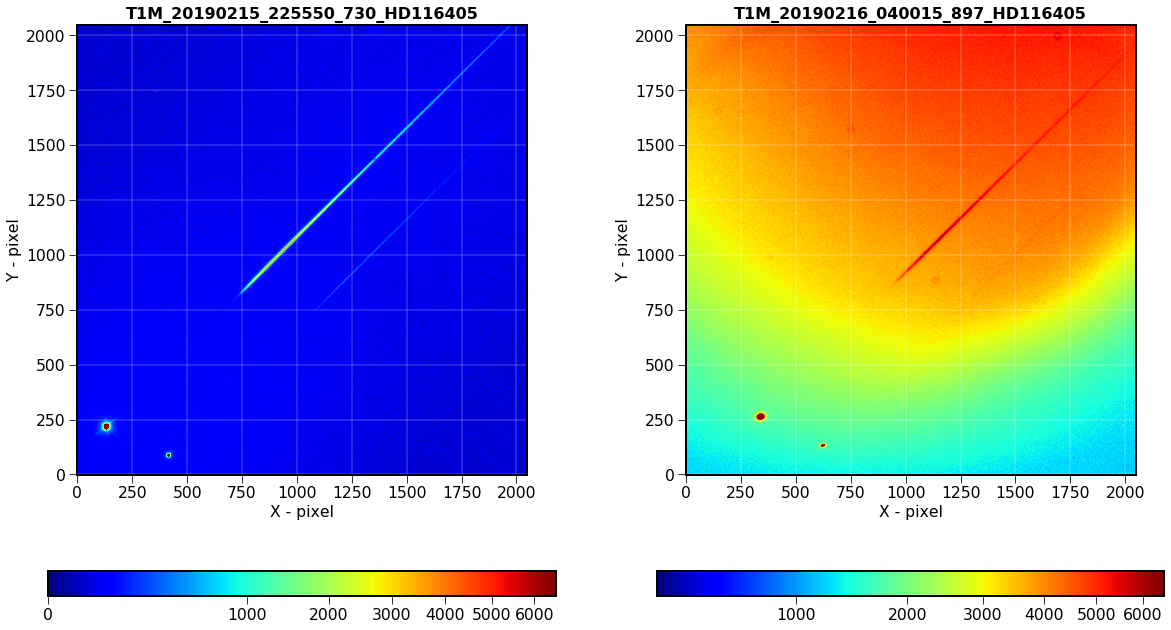

In [18]:
Show2Images(data1,data2,title1,title2,cutmax=10,normflag=True)

In [19]:
cutimg1=data1[0:750,0:750]
cutimg2=data2[0:750,0:750]

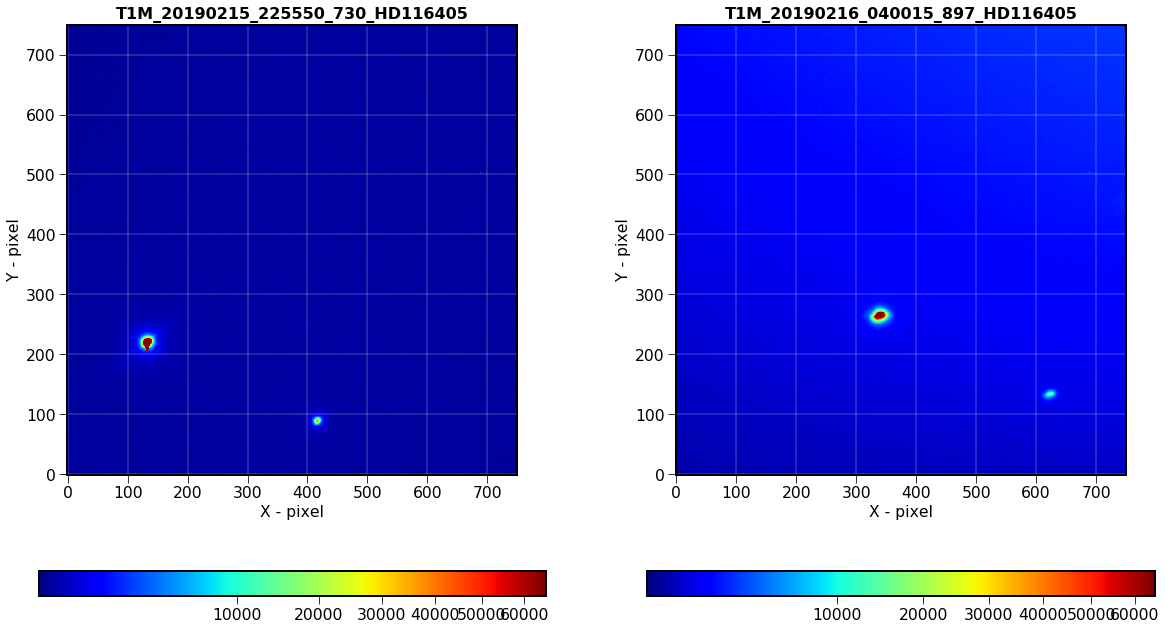

In [20]:
Show2Images(cutimg1,cutimg2,title1,title2,cutmax=1,normflag=True)

# Find sources

In [21]:
sources1=FindSources(cutimg1)
sources2=FindSources(cutimg2)

In [22]:
positions1 = (sources1['xcentroid'], sources1['ycentroid'])
positions2 = (sources2['xcentroid'], sources2['ycentroid'])

In [23]:
for col in sources1.colnames:    
    sources1[col].info.format = '%.8g'  # for consistent table output
print("sources1") 
print(sources1)  

sources1
 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  1 416.82349 89.841687 0.55505862 ...   0 42997.851 792.12038   -7.246978
  2 131.36828 220.22083 0.39960252 ...   0 64594.423 725.86477  -7.1521393
  3 135.39845 222.28779 0.32487395 ...   0 64925.375  821.6427  -7.2867075
  4 400.91073 247.45616 0.74895549 ...   0 122.06686 1.8371896 -0.66038492


In [24]:
for col in sources2.colnames:    
    sources2[col].info.format = '%.8g'  # for consistent table output
print("sources2") 
print(sources2)  

sources2
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
  1 623.38927 134.69142 0.49776238 ...   0 13651.764 6.2190272 -1.9843061
  2 335.89625 263.81104 0.33908469 ...   0 61930.916 23.421514 -3.4240374
  3 341.76198 266.19114 0.31754449 ...   0  62120.97 22.858441 -3.3976165


In [25]:
sources1

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,416.82349,89.841687,0.55505862,0.24712491,-0.027605732,169,0,42997.851,792.12038,-7.246978
2,131.36828,220.22083,0.39960252,0.058765839,0.64615658,169,0,64594.423,725.86477,-7.1521393
3,135.39845,222.28779,0.32487395,-0.10523389,0.29876359,169,0,64925.375,821.6427,-7.2867075
4,400.91073,247.45616,0.74895549,0.20446992,0.094260166,169,0,122.06686,1.8371896,-0.66038492


In [26]:
sources2

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,623.38927,134.69142,0.49776238,0.29069922,-0.71362668,169,0,13651.764,6.2190272,-1.9843061
2,335.89625,263.81104,0.33908469,0.30975638,-0.34796614,169,0,61930.916,23.421514,-3.4240374
3,341.76198,266.19114,0.31754449,0.058464045,-0.27117751,169,0,62120.97,22.858441,-3.3976165


In [27]:
width=30
x01,y01,xmin1,xmax1,ymin1,ymax1=GetExtractionParam(sources1,width=width)
x02,y02,xmin2,xmax2,ymin2,ymax2=GetExtractionParam(sources2,width=width)

In [28]:
vignette1=data1[ymin1:ymax1,xmin1:xmax1]
vignette2=data2[ymin2:ymax2,xmin2:xmax2]

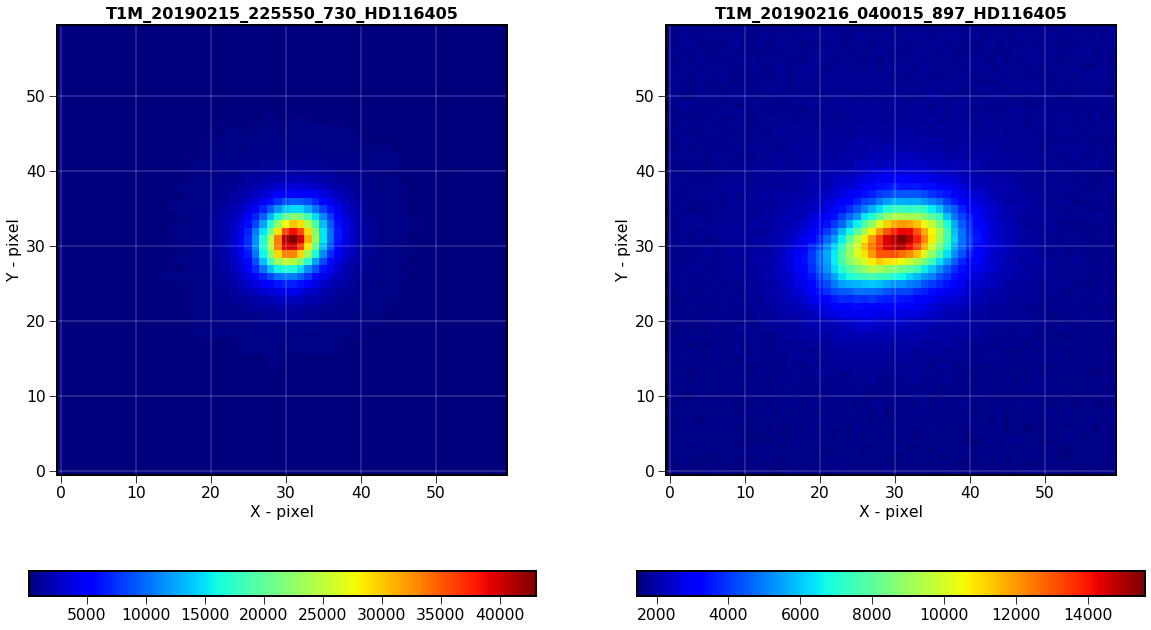

In [29]:
Show2Images(vignette1,vignette2,title1,title2,cutmax=1,normflag=False)

# Background

In [30]:
bkg1=GetBackground(vignette1)
bkg2=GetBackground(vignette2)

(116.19138774181718, 114.51209973267103, 18.94026555963478)
(1657.2766589698554, 1658.3428885717422, 69.25500800458434)


In [31]:
#mask = make_source_mask(data, snr=3, npixels=5, dilate_size=11)
mask1 = make_source_mask(vignette1, snr=3, npixels=5)
mask2 = make_source_mask(vignette2, snr=3, npixels=5)
mean1, median1, std1 = sigma_clipped_stats(vignette1, sigma=3.0, mask=mask1)
mean2, median2, std2 = sigma_clipped_stats(vignette2, sigma=3.0, mask=mask2)

In [90]:
print(median1,median2)

114.51209973267103 1658.3428885717422


In [32]:
signal1=vignette1-median1
signal2=vignette2-median2

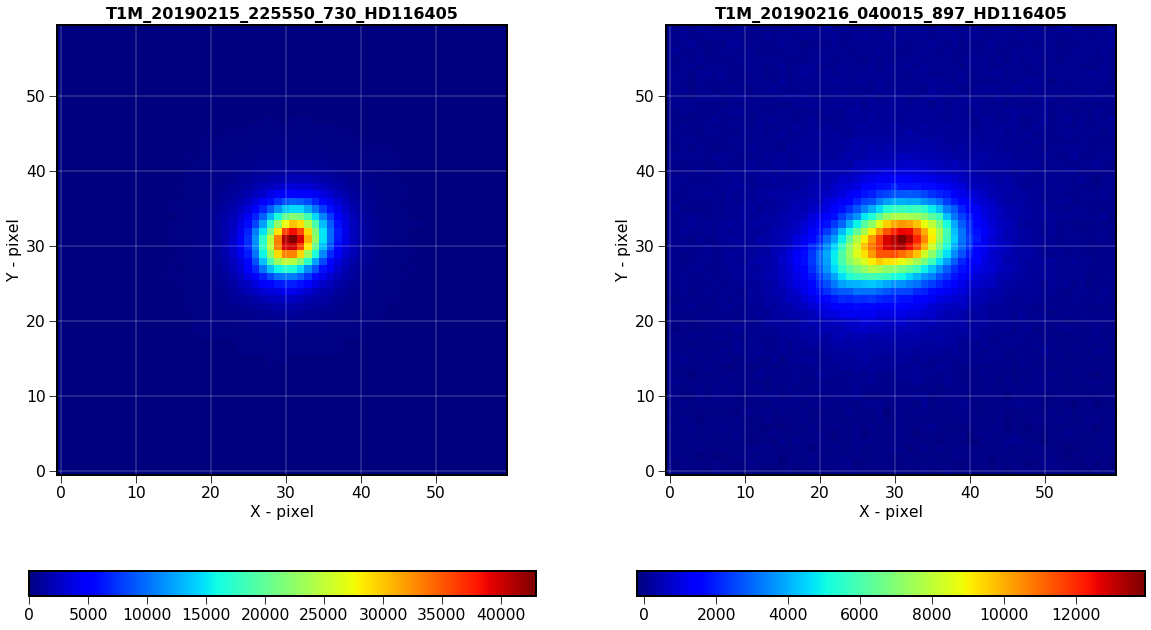

In [33]:
Show2Images(signal1,signal2,title1,title2,cutmax=1,normflag=False)

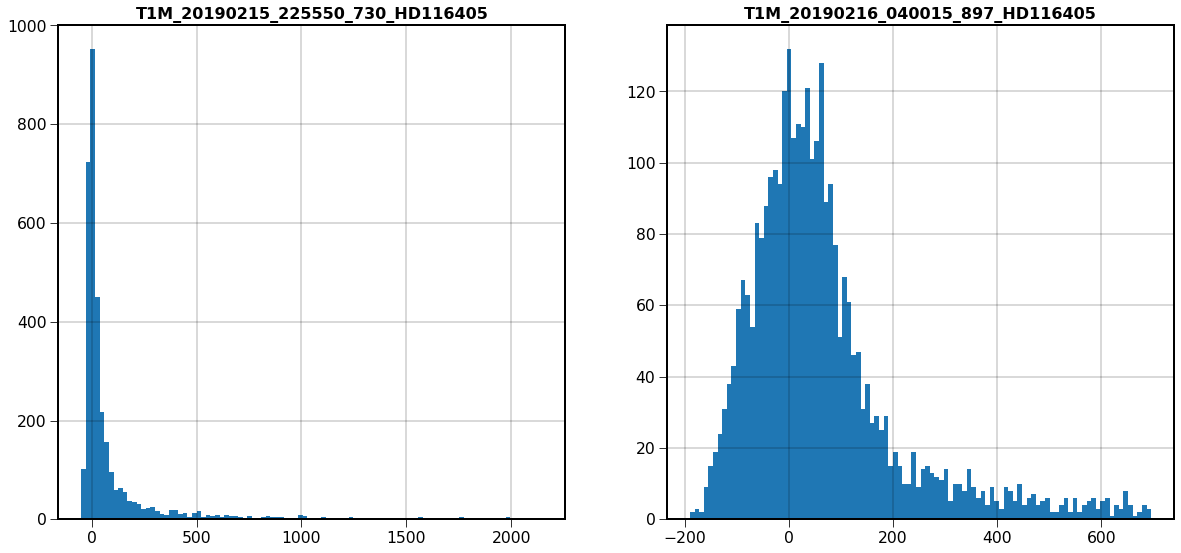

In [34]:
Show2Histo(signal1,signal2,title1,title2,cutmax=20)

# Method 1 : Aperture Photometry

https://photutils.readthedocs.io/en/stable/aperture.html

## Circular Aperture

In [35]:
from photutils import aperture_photometry
from photutils import CircularAperture

In [36]:
apertures1 = CircularAperture((width,width), r=25.)
apertures2 = CircularAperture((width,width), r=25.)

## Aperture Sum 

- aperture sum in ADU

In [37]:
phot_table1 = aperture_photometry(signal1, apertures1)
phot_table2 = aperture_photometry(signal2, apertures2)

In [38]:
for col in phot_table1.colnames:    
    phot_table1[col].info.format = '%.8g'  # for consistent table output

In [39]:
for col in phot_table2.colnames:    
    phot_table2[col].info.format = '%.8g'  # for consistent table output

In [40]:
phot_table1

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,30,30,2740286.8


In [41]:
phot_table2

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,30,30,1895507


## Loop on all pixel radius

In [42]:

all_r=np.arange(1,30)
N=len(all_r)
all_aps1=np.zeros(N)
all_aps2=np.zeros(N)
idx=0
for r in all_r:
    aperture= CircularAperture((width,width), r=r)
    phot_table1 = aperture_photometry(signal1, aperture)
    phot_table2 = aperture_photometry(signal2, aperture)
    aps1=phot_table1["aperture_sum"][0]
    aps2=phot_table2["aperture_sum"][0]
    all_aps1[idx]=aps1
    all_aps2[idx]=aps2
    idx+=1
maxaps1=all_aps1.max()
maxaps2=all_aps2.max()

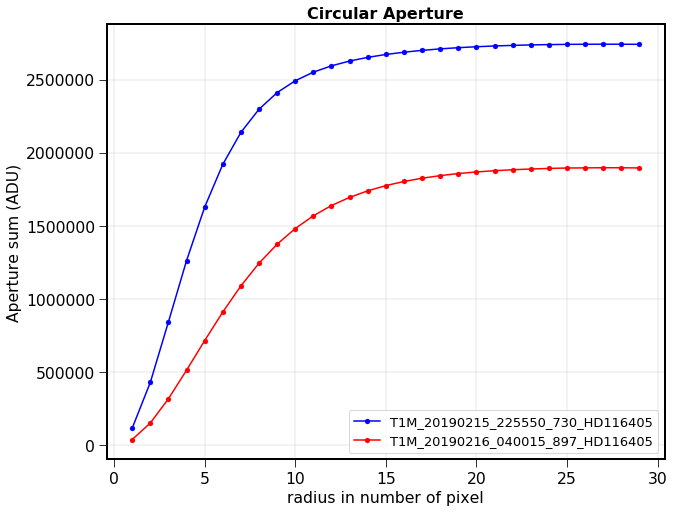

In [43]:
plt.figure(figsize=(10,8))
plt.plot(all_r,all_aps1,"b-o",label=title1)
plt.plot(all_r,all_aps2,"r-o",label=title2)
plt.grid()
plt.xlabel("radius in number of pixel")
plt.ylabel("Aperture sum (ADU)")
plt.title("Circular Aperture")
plt.legend()

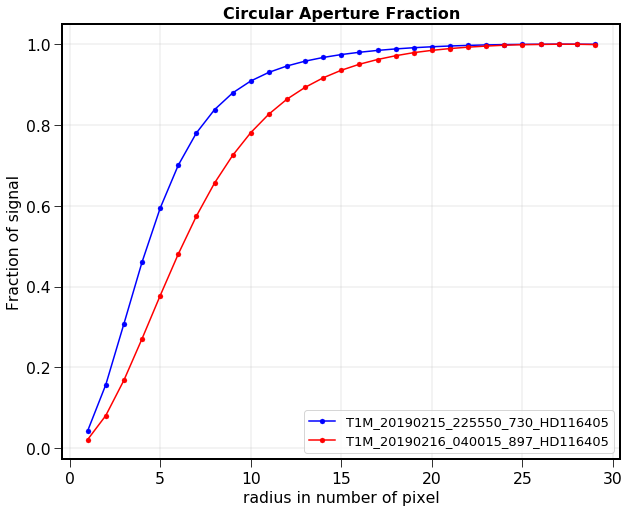

In [44]:
plt.figure(figsize=(10,8))
plt.plot(all_r,all_aps1/maxaps1,"b-o",label=title1)
plt.plot(all_r,all_aps2/maxaps2,"r-o",label=title2)
plt.grid()
plt.xlabel("radius in number of pixel")
plt.ylabel("Fraction of signal")
plt.title("Circular Aperture Fraction")
plt.legend()

## Annulus photometry

In [45]:
from photutils import CircularAperture, CircularAnnulus

### Create annulus aperture

In [46]:
annulus_aperture = CircularAnnulus((width,width), r_in=25, r_out=30)

### Create a mask

In [47]:
annulus_masks = annulus_aperture.to_mask(method='center')

### Get the annular data

In [48]:
annulus_data1 = annulus_masks[0].multiply(vignette1)
annulus_data2 = annulus_masks[0].multiply(vignette2)

### Compute median background

In [49]:
mask = annulus_masks[0].data
annulus_data1_1d = annulus_data1[mask > 0]
annulus_data2_1d = annulus_data2[mask > 0]

In [50]:
 _, median1_sigclip, _ = sigma_clipped_stats(annulus_data1_1d)
 _, median2_sigclip, _ = sigma_clipped_stats(annulus_data2_1d)

In [51]:
print( median1_sigclip, median2_sigclip)

113.20178948139241 1657.740030137022


In [52]:
background1 = median1_sigclip * annulus_aperture.area()
background2 = median2_sigclip * annulus_aperture.area()

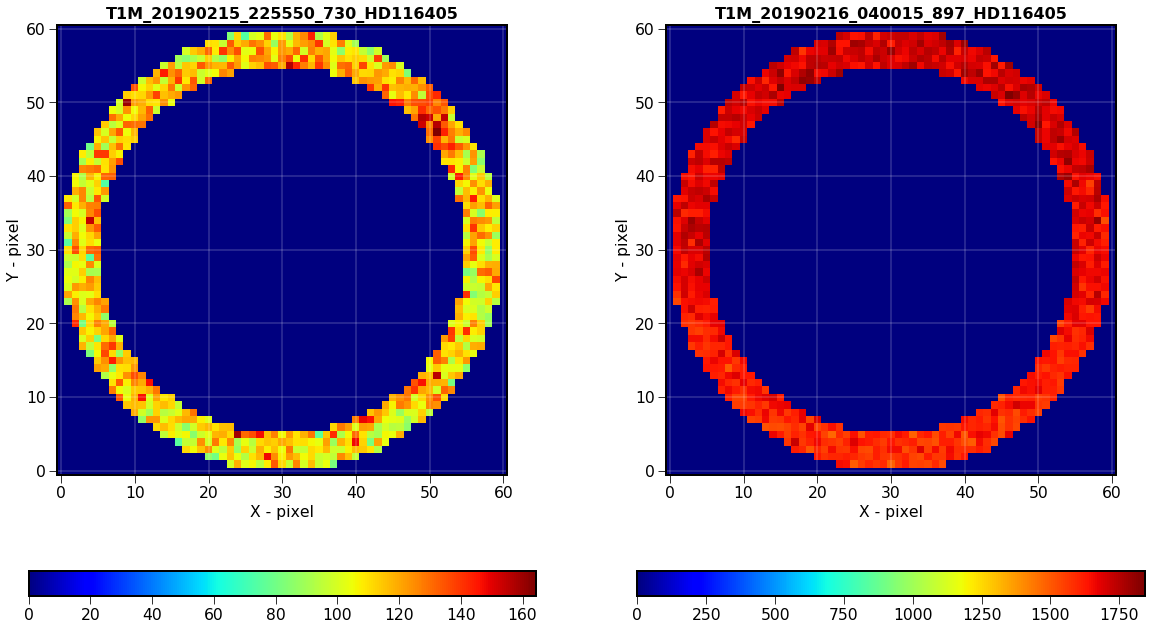

In [53]:
Show2Images(annulus_data1,annulus_data2,title1,title2,cutmax=1,normflag=False)

In [54]:
fullbg1 = np.full_like(annulus_data1, median1_sigclip)
fullbg2 = np.full_like(annulus_data2, median2_sigclip)

In [55]:
bg1=annulus_masks[0].multiply(fullbg1)
bg2=annulus_masks[0].multiply(fullbg2)

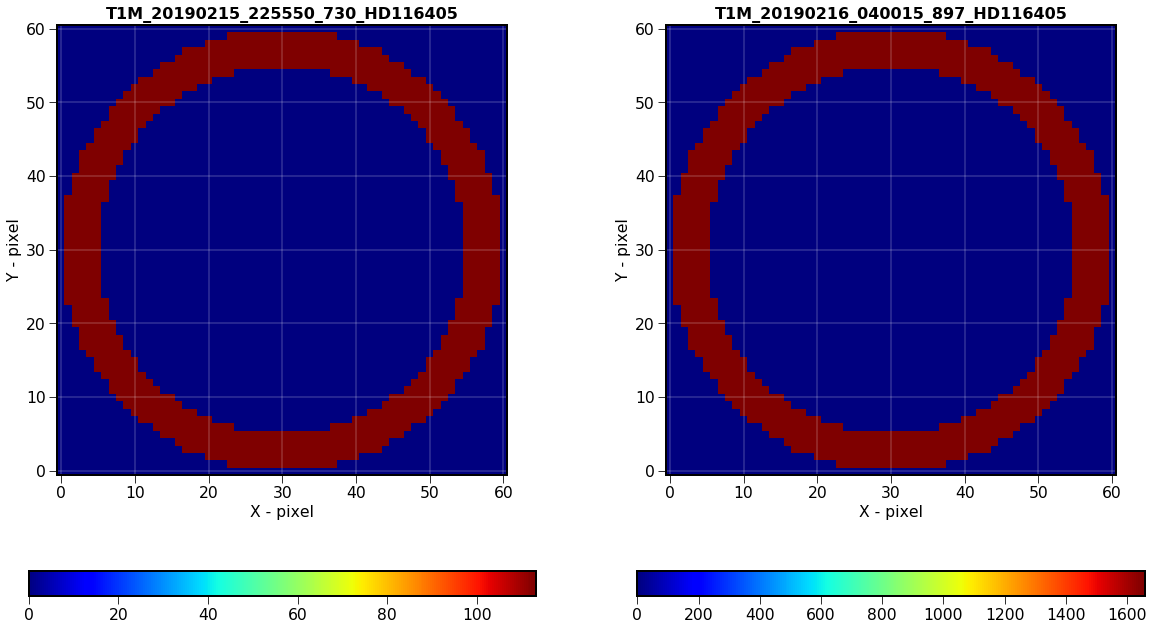

In [56]:
Show2Images(bg1,bg2,title1,title2,cutmax=1,normflag=False)

In [57]:
signal1=annulus_data1-bg1
signal2=annulus_data2-bg2

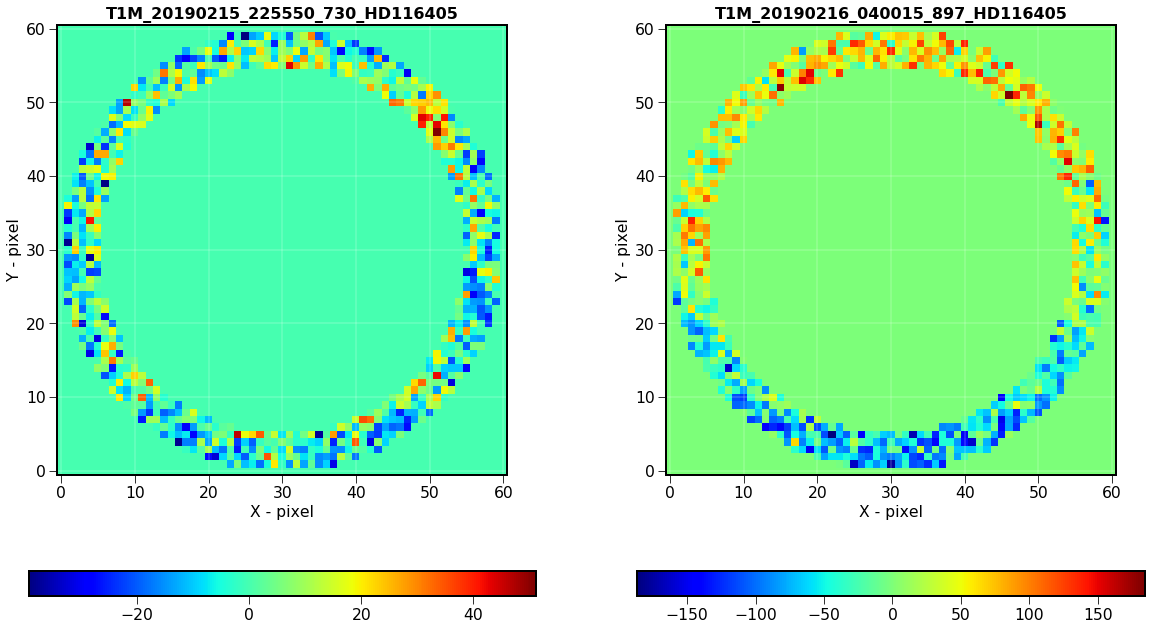

In [58]:
Show2Images(signal1,signal2,title1,title2,cutmax=1,normflag=False)

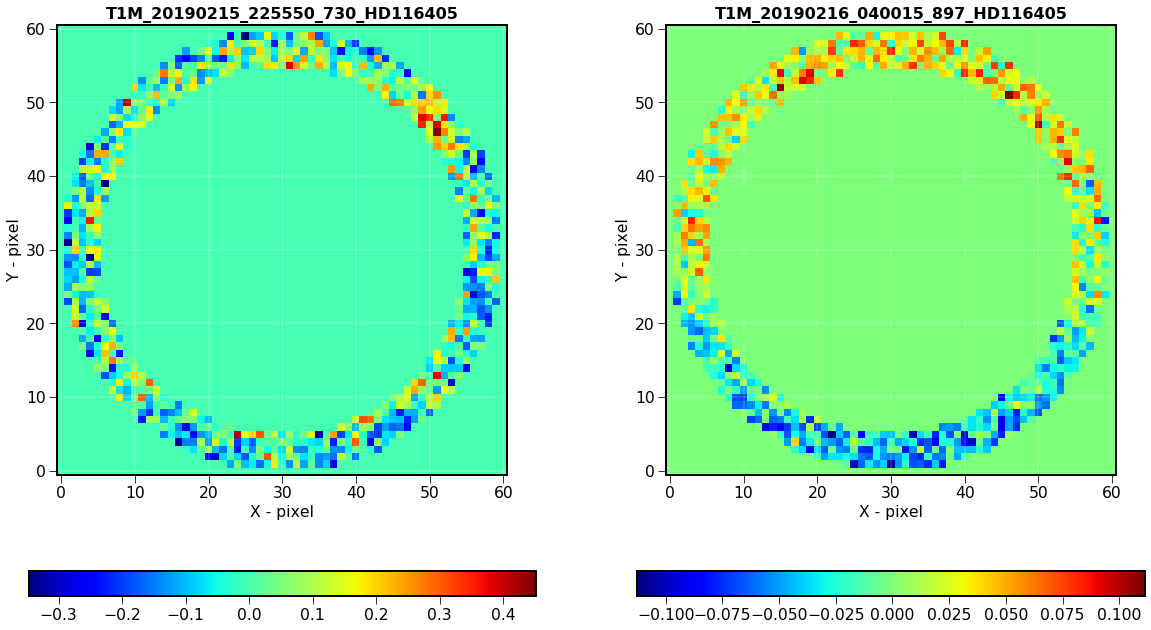

In [59]:
Show2Images(signal1/median1_sigclip,signal2/median2_sigclip,title1,title2,cutmax=1,normflag=False)

In [60]:
profileY1=np.sum(signal1,axis=1)
profileY2=np.sum(signal2,axis=1)
profileX1=np.sum(signal1,axis=0)
profileX2=np.sum(signal2,axis=0)

Text(0.5, 0.98, 'Background gradient in Y')

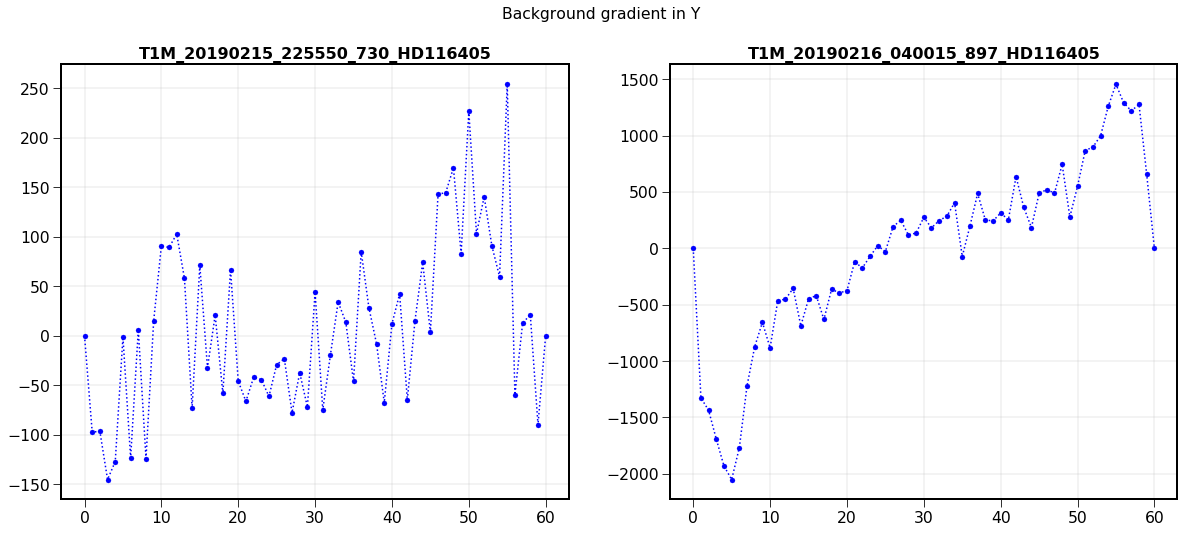

In [61]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(profileY1,"b:o")
plt.grid()
plt.title(title1)
plt.subplot(122)
plt.plot(profileY2,"b:o")
plt.grid()
plt.title(title2)
plt.suptitle("Background gradient in Y")

Text(0.5, 0.98, 'Background gradient in X')

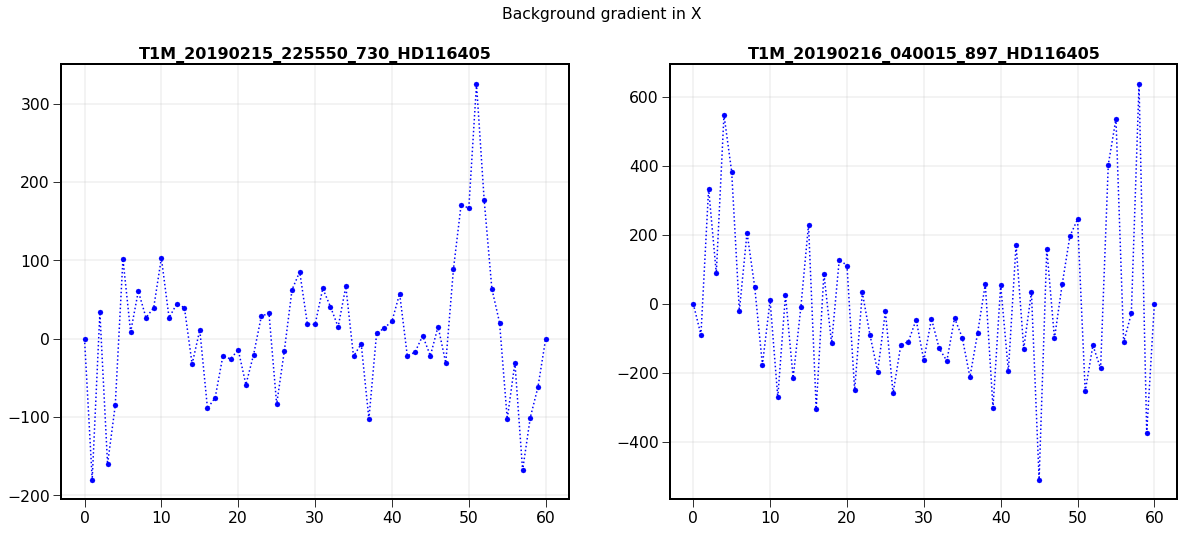

In [62]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(profileX1,"b:o")
plt.title(title1)
plt.grid()
plt.subplot(122)
plt.plot(profileX2,"b:o")
plt.grid()
plt.title(title2)
plt.suptitle("Background gradient in X")

### Table

In [63]:
gel=4.8 # electrons per ADU

In [64]:
error1 = np.sqrt(vignette1/gel) # should be better calculated
phot1 = aperture_photometry(vignette1, apertures1,error=error1)
phot1['annulus_median'] = median1_sigclip
phot1['aper_bkg'] = median1_sigclip * apertures1.area()
phot1['aper_sum_bkgsub'] = phot1['aperture_sum'] - phot1['aper_bkg']
for col in phot1.colnames:
    phot1[col].info.format = '%.8g'  # for consistent table output
print(phot1)

 id xcenter ycenter aperture_sum ... annulus_median  aper_bkg aper_sum_bkgsub
      pix     pix                ...                                         
--- ------- ------- ------------ ... -------------- --------- ---------------
  1      30      30    2965130.8 ...      113.20179 222271.19       2742859.6


In [65]:
phot1

id,xcenter,ycenter,aperture_sum,aperture_sum_err,annulus_median,aper_bkg,aper_sum_bkgsub
,pix,pix,,,,,
int64,float64,float64,float64,float64,float64,float64,float64
1,30,30,2965130.8,785.96157,113.20179,222271.19,2742859.6


In [66]:
error2 = np.sqrt(vignette2/gel) # should be better calculated
phot2 = aperture_photometry(vignette2, apertures2,error=error2)
phot2['annulus_median'] = median2_sigclip
phot2['aper_bkg'] = median2_sigclip * apertures2.area()
phot2['aper_sum_bkgsub'] = phot2['aperture_sum'] - phot2['aper_bkg']
for col in phot2.colnames:
    phot2[col].info.format = '%.8g'  # for consistent table output
print(phot2)

 id xcenter ycenter aperture_sum ... annulus_median  aper_bkg aper_sum_bkgsub
      pix     pix                ...                                         
--- ------- ------- ------------ ... -------------- --------- ---------------
  1      30      30    5151655.6 ...        1657.74 3254964.9       1896690.7


In [67]:
phot2

id,xcenter,ycenter,aperture_sum,aperture_sum_err,annulus_median,aper_bkg,aper_sum_bkgsub
,pix,pix,,,,,
int64,float64,float64,float64,float64,float64,float64,float64
1,30,30,5151655.6,1035.9834,1657.74,3254964.9,1896690.7


# Method 3 :PSF Photometry

https://photutils.readthedocs.io/en/stable/psf.html


In [68]:
from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

## Config

In [69]:
#sigma_psf=4.5 # pixel
sigma_psf=10 # pixel

## Compute Background

In [70]:
bkgrms = MADStdBackgroundRMS()
std1 = bkgrms(vignette1)
std2 = bkgrms(vignette2)

In [71]:
std1,std2

(24.147032165826378, 88.04463661689009)

In [72]:
iraffind1 = IRAFStarFinder(threshold=3.5*std1,
...                           fwhm=sigma_psf*gaussian_sigma_to_fwhm,
...                           minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
...                           sharplo=0.0, sharphi=2.0)

In [73]:
iraffind2 = IRAFStarFinder(threshold=3.5*std2,
...                           fwhm=sigma_psf*gaussian_sigma_to_fwhm,
...                           minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
...                           sharplo=0.0, sharphi=2.0)

In [74]:
daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)

In [75]:
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = IntegratedGaussianPRF(sigma=sigma_psf)
from photutils.psf import IterativelySubtractedPSFPhotometry

In [76]:
photometry1 = IterativelySubtractedPSFPhotometry(finder=iraffind1,
...                                                 group_maker=daogroup,
...                                                 bkg_estimator=mmm_bkg,
...                                                 psf_model=psf_model,
...                                                 fitter=LevMarLSQFitter(),
...                                                 niters=1, fitshape=(21,21))

In [77]:
photometry2 = IterativelySubtractedPSFPhotometry(finder=iraffind2,
...                                                 group_maker=daogroup,
...                                                 bkg_estimator=mmm_bkg,
...                                                 psf_model=psf_model,
...                                                 fitter=LevMarLSQFitter(),
...                                                 niters=1, fitshape=(21,21))

In [78]:
result_tab1 = photometry1(image=vignette1)

In [79]:
for col in result_tab1.colnames:
    result_tab1[col].info.format = '%.8g'  # for consistent table output
print(result_tab1)

   x_0      x_fit      y_0      y_fit   ...  x_0_unc    y_0_unc   iter_detected
--------- --------- --------- --------- ... ---------- ---------- -------------
30.778227 30.586448 30.893807 30.743621 ... 0.94968296 0.94944545             1


In [80]:
result_tab1

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int32
30.778227,30.586448,30.893807,30.743621,2751341.1,6185549,1,1,306221.68,0.94968296,0.94944545,1


In [81]:
residual_image1 = photometry1.get_residual_image()

In [82]:
result_tab2 = photometry2(image=vignette2)

In [83]:
for col in result_tab2.colnames:
    result_tab2[col].info.format = '%.8g'  # for consistent table output
print(result_tab2)

   x_0      x_fit      y_0      y_fit   ...  x_0_unc    y_0_unc   iter_detected
--------- --------- --------- --------- ... ---------- ---------- -------------
29.820076 29.837059 30.209362 30.568926 ... 0.56177209 0.56218576             1


In [84]:
result_tab2

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int32
29.820076,29.837059,30.209362,30.568926,1874438.4,3592985,1,1,105303.65,0.56177209,0.56218576,1


In [85]:
residual_image2 = photometry2.get_residual_image()

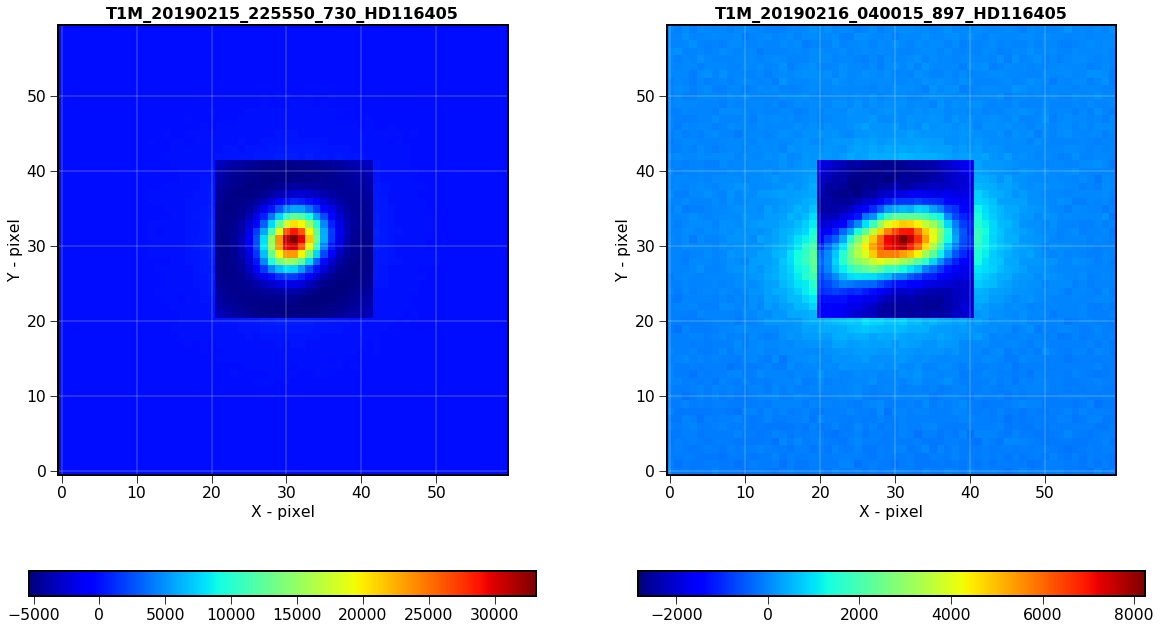

In [86]:
Show2Images(residual_image1 ,residual_image2 ,title1,title2,cutmax=1,normflag=False)

# Background


https://photutils.readthedocs.io/en/stable/background.html

In [87]:
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg1 = Background2D(vignette1, (20,20), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
bkg2 = Background2D(vignette2, (20,20), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

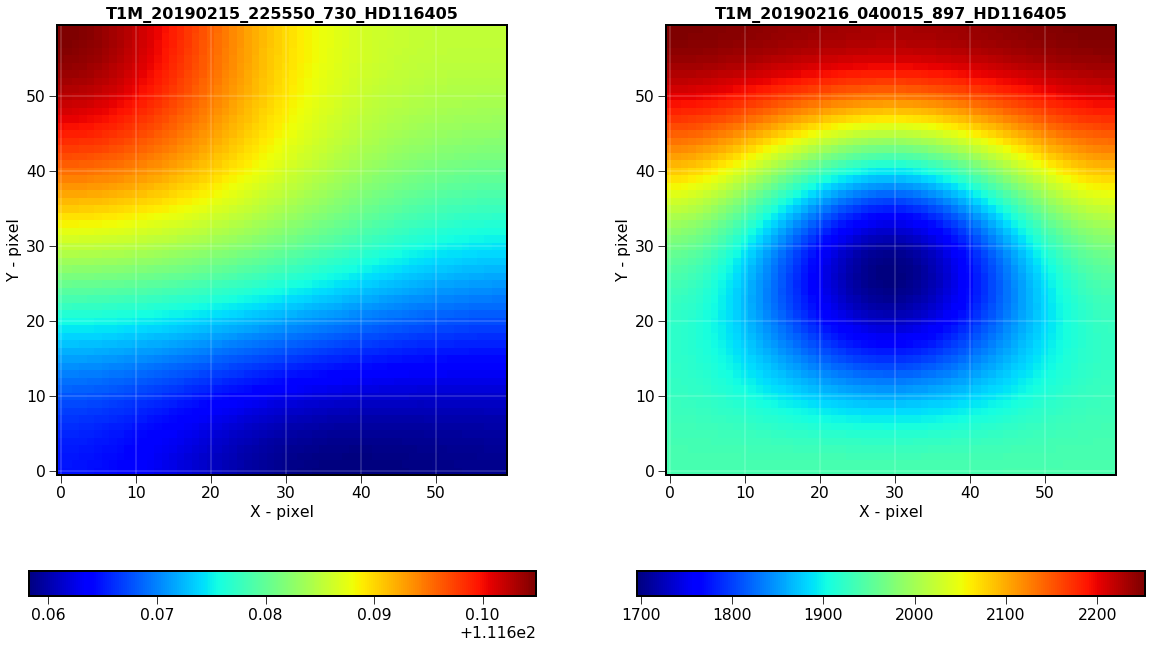

In [88]:
Show2Images(bkg1.background ,bkg2.background ,title1,title2,cutmax=1,normflag=False)